# Загрузка

In [1]:
target = '% площади сдвига (вязк.сост.) (1138)'

In [2]:
ls_columns_output = [
#     '№ партии',
#     '№ плавки',
    'марка стали',
    'диаметр',
    'толщина стенки',
    'Гр. прочн.',
    '1 зона по ВТР закалка',
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка',
    'шаг балок закалочная печь, сек',
    'Скорость прохождения трубы через спрейер, м/с', 
    't˚ C трубы после спреера',
    '1 зона ВТР и уставка отпуск', 
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск',
    'шаг балок отпускная печь, сек',
    'C',
    'Mn',
    'Si',
    'P',
    'S',
    'Cr',
    'Ni',
    'Cu',
    'Al',
    'V',
    'Ti',
    'Nb',
    'Mo',
    'N',
    'B',
    'C-coef',
    'Параметр закалка',
    'Параметр отпуск',
    'Параметр отпуск новый V',
    'Величина зерна',
    'Тип предела текучести (1186)',
#     'Дата термообработки',
    'ICD',
#     'Примечание',
    'длина трубы'
    ]

In [3]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random
from datetime import datetime

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb


In [4]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
from sklearn import model_selection
import matplotlib.pyplot as plt
import os
from time import time
from datetime import datetime
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\save_lib.ipynb


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
df = pd.read_csv('DATA/prepared/prepared_to_saw_gp.csv', low_memory=False)

In [8]:
df_proportion_viscous = pd.read_excel('DATA/source/exp/prepared/table_proportion_viscous_50.xlsx')

In [9]:
df_proportion_viscous = df_proportion_viscous[['№ плавки', '№ партии','% площади сдвига (вязк.сост.) (1138)']]

In [10]:
df_proportion_viscous.shape

(29553, 3)

In [11]:
df_proportion_viscous = df_proportion_viscous.groupby(['№ плавки', '№ партии'])['% площади сдвига (вязк.сост.) (1138)'].mean()

In [12]:
df_proportion_viscous = pd.DataFrame(df_proportion_viscous)

In [13]:
df_proportion_viscous.reset_index(inplace=True)

In [14]:
df_proportion_viscous.shape

(4824, 3)

In [15]:
df_proportion_viscous['№ плавки'] = df_proportion_viscous['№ плавки'].astype(str)
df_proportion_viscous['№ плавки'] = df_proportion_viscous['№ плавки'].apply(lambda x: x.lower())
df_proportion_viscous['№ партии'] = df_proportion_viscous['№ партии'].astype(str)
df['№ плавки'] = df['№ плавки'].astype(str)
df['№ плавки'] = df['№ плавки'].apply(lambda x: x.lower())
df['№ партии'] = df['№ партии'].astype(str)

In [16]:
df = pd.merge(df, df_proportion_viscous, on=['№ плавки', '№ партии'], how='outer')

In [17]:
def bath2spr(df):
    L = 8.4
    df['Скорость прохождения трубы через спрейер, м/с'] = L/df['время выдержки в закалочной ванне, сек.']
    df['t˚ C трубы после спреера'] = df['t˚ C трубы после ванны']
    return df

In [18]:
bath = df[~df['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_ = df[df['время выдержки в закалочной ванне, сек.'].isnull()].copy()


bath = bath2spr(bath)

df = pd.concat([df_, bath])
df.reset_index(inplace=True, drop=True)

In [19]:
df.shape

(27781, 202)

In [20]:
df = len_pipe(df)

df = mean_chem(df)

df = calc_all_features(df)

C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb:127: RuntimeWarning: divide by zero encountered in log10
  "\n",


In [21]:
df = df[df['шаг балок закалочная печь, сек'] < 100]
df = df[df['шаг балок закалочная печь, сек'] >= 24]
df = df[df['шаг балок отпускная печь, сек'] >= 24]
df = df[df['Скорость прохождения трубы через спрейер, м/с'] <= 1]
df = df[df['t˚ C трубы после спреера'] > 1]
df = df[df['t˚ C трубы после спреера'] <= 250]
df = df[df['2 зона ВТР и уставка отпуск'] > 400]
df = df[df['4 зона ВТР и уставка отпуск'] > 400]

In [22]:
df_.shape

(26681, 202)

In [23]:
df_['Дата термообработки'] = df_['Дата термообработки'].apply(lambda x: str(x).replace(' 00:00:00', ''))
df_['Дата термообработки'] = df_['Дата термообработки'].apply(lambda x: str(x).replace('-', '.'))

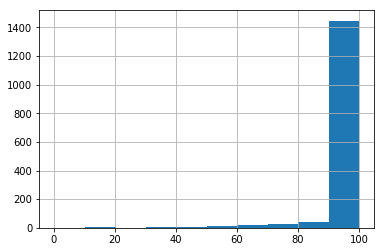

In [76]:
df_[target].hist()

In [25]:
tmp = []
for x in df_['Дата термообработки']:
    try:
        tmp.append(datetime.strptime(x, "%d.%m.%Y"))
    except ValueError:
        tmp.append(datetime.strptime(x, "%Y.%m.%d"))
df_['Дата термообработки'] = tmp

ValueError: time data 'nan' does not match format '%Y.%m.%d'

In [26]:
df[ls_columns_output+[target]].dropna().shape

(1471, 40)

In [28]:
ls_train = ls_columns_output.copy()
# ls_train.remove('Дата термообработки')
ls_train.remove('марка стали')
ls_train.remove('Гр. прочн.')

# for s in ls_to_del:
#     ls_train.remove(s)

In [29]:
df_ = df[ls_train+[target]].dropna()

X, X_valid, y, y_valid = train_test_split(df_[ls_train], df_[target], test_size=0.3)

In [30]:
X.shape, X_valid.shape

((1094, 37), (469, 37))

In [69]:
def print_and_return_score(x, y, est, verb=1):
    y_pred = est.predict(x)
#     scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
#     corr = pearsonr(y, y_pred)
    
    if verb==1:
#         print('Score: ', round(scr, 2))
        print('R^2: ', round(r2, 2))
        print('MAE: ', round(mae, 2))
        print('MSE: ', round(mse, 2))
#         print('Correlation: ', round(corr[0][1], 2))
    return [r2, mae, mse]

In [32]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
len(ls_train)

37

In [37]:
rfc = RandomForestRegressor(max_features = 13, max_depth = 18, min_samples_leaf = 1, n_estimators=50, criterion='mse')
rfc.fit(X_train, y_train)

scr, mae, mse, corr = print_and_return_score(X_test, y_test, rfc)

Score:  0.13
R^2:  0.13
MAE:  2.82
MSE:  70.63
Correlation:  0.57


In [35]:
val = rfc.feature_importances_
lab = ls_train
dict_feat_import = dict(zip(lab, val))
ls_to_del = []
for feat, imp in zip(lab, val):
    print(feat, '  ', imp.round(2))
    if imp.round(2) < 0.01:
        ls_to_del.append(feat)

диаметр    0.01
толщина стенки    0.05
1 зона по ВТР закалка    0.01
2 зона по ВТР закалка    0.0
3 зона по ВТР закалка    0.02
шаг балок закалочная печь, сек    0.04
Скорость прохождения трубы через спрейер, м/с    0.02
t˚ C трубы после спреера    0.03
1 зона ВТР и уставка отпуск    0.03
2 зона ВТР и уставка отпуск    0.02
3 зона ВТР и уставка отпуск    0.03
4 зона ВТР и уставка отпуск    0.02
5 зона ВТР и уставка отпуск    0.02
шаг балок отпускная печь, сек    0.09
C    0.02
Mn    0.01
Si    0.01
P    0.02
S    0.01
Cr    0.01
Ni    0.04
Cu    0.04
Al    0.01
V    0.04
Ti    0.01
Nb    0.08
Mo    0.02
N    0.01
B    0.0
C-coef    0.02
Параметр закалка    0.02
Параметр отпуск    0.03
Параметр отпуск новый V    0.04
Величина зерна    0.04
Тип предела текучести (1186)    0.01
ICD    0.02
длина трубы    0.11


In [38]:
ls_to_del

['2 зона по ВТР закалка', 'B']

In [39]:
lr = LinearRegression()
lr.fit(X_train, y_train)

scr, mae, mse, corr = print_and_return_score(X_test, y_test, lr)

Score:  0.11
R^2:  0.11
MAE:  4.77
MSE:  72.07
Correlation:  0.42


In [41]:

from sklearn.linear_model import RidgeCV, Lasso, LassoLars, BayesianRidge,SGDRegressor, Perceptron, HuberRegressor

l = HuberRegressor()
l.fit(X_train, y_train)

scr, mae, mse, corr = print_and_return_score(X_test, y_test, l)

Score:  -0.02
R^2:  -0.02
MAE:  2.94
MSE:  82.99
Correlation:  0.18


In [42]:
c = 1
r = RidgeCV(alphas=[0.1, 1.0, 10.0])
r.fit(X_train, y_train)

scr, mae, mse, corr = print_and_return_score(X_test, y_test, lr)
r.alpha_

Score:  0.11
R^2:  0.11
MAE:  4.77
MSE:  72.07
Correlation:  0.42


0.1

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

g = GradientBoostingRegressor()
g.fit(X_train, y_train)

scr, mae, mse, corr = print_and_return_score(X_test, y_test, g)

Score:  0.03
R^2:  0.03
MAE:  2.93
MSE:  78.8
Correlation:  0.49


In [44]:
# import tensorflow as tf
import theano
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'c:\\Temp\\try_flags_lwrs4941.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [73]:
model = Sequential()
model.add(Dense(units=4,input_dim=X_train.shape[1]))
model.add(Activation('tanh'))
model.add(Dense(units=1))
model.compile(
        loss=keras.losses.logcosh,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
            optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.85, beta_2=0.98, epsilon=1e-7, decay=1e-7, amsgrad=True)
#         optimizer=keras.optimizers.RMSprop(lr=0.01, rho=0.8, epsilon=None, decay=0.0)
#     optimizer=keras.optimizers.SGD(lr=0.001, momentum = 0.8, decay=1e-6)
#     optimizer = keras.optimizers.Nadam(lr=0.003, beta_1=0.99, beta_2=0.999, epsilon=None, schedule_decay=0.005)
        )

model.fit(X_train, y_train, batch_size = 16, epochs=100, shuffle=True)

Epoch 1/100
875/875 [==============================] - 2s 2ms/step - loss: 94.8253 - mean_absolute_error: 95.5183
Epoch 2/100
875/875 [==============================] - 1s 582us/step - loss: 92.0764 - mean_absolute_error: 92.7696
Epoch 3/100
875/875 [==============================] - 1s 599us/step - loss: 89.3369 - mean_absolute_error: 90.0300
Epoch 4/100
875/875 [==============================] - 1s 582us/step - loss: 86.5979 - mean_absolute_error: 87.2910
Epoch 5/100
875/875 [==============================] - 1s 579us/step - loss: 83.8624 - mean_absolute_error: 84.5555
Epoch 6/100
875/875 [==============================] - 1s 604us/step - loss: 81.1309 - mean_absolute_error: 81.8232
Epoch 7/100
875/875 [==============================] - 1s 594us/step - loss: 78.4107 - mean_absolute_error: 79.1038
Epoch 8/100
875/875 [==============================] - 1s 596us/step - loss: 75.6995 - mean_absolute_error: 76.3927
Epoch 9/100
875/875 [==============================] - 1s 598us/step - los

875/875 [==============================] - 1s 580us/step - loss: 2.2103 - mean_absolute_error: 2.3645
Epoch 72/100
875/875 [==============================] - 1s 579us/step - loss: 2.2103 - mean_absolute_error: 2.3602
Epoch 73/100
875/875 [==============================] - 1s 572us/step - loss: 2.2104 - mean_absolute_error: 2.3671
Epoch 74/100
875/875 [==============================] - 1s 590us/step - loss: 2.2103 - mean_absolute_error: 2.3624
Epoch 75/100
875/875 [==============================] - 1s 588us/step - loss: 2.2103 - mean_absolute_error: 2.3645
Epoch 76/100
875/875 [==============================] - 1s 579us/step - loss: 2.2104 - mean_absolute_error: 2.3591
Epoch 77/100
875/875 [==============================] - 1s 586us/step - loss: 2.2103 - mean_absolute_error: 2.3675
Epoch 78/100
875/875 [==============================] - 1s 573us/step - loss: 2.2104 - mean_absolute_error: 2.3589
Epoch 79/100
875/875 [==============================] - 1s 591us/step - loss: 2.2103 - mean_a

In [74]:
scr, mae, mse = print_and_return_score(X_test, y_test, model)

R^2:  -0.07
MAE:  2.5
MSE:  86.41
